# 学習と評価
 - 二値分類モデルの並列を行い，マルチラベル問題を解く
 - FaceNetの利用

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from pathlib import Path

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.8.0'

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
from sklearn.model_selection import KFold

## データのロード

- 画像サイズは224×224

In [7]:
df = pd.read_csv("data1.csv")

In [8]:
df

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,6269,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,272998,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,274783,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,430823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,208848,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80,185955,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,313100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
82,369866,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,124821,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## FaceNetで埋め込み

メモ：```\Lib\site-packages\facenet\src\facenet.py```の408行目をtensorflow v2仕様に書き換える必要がある

In [9]:
from face_embedding import FaceEmbedding

In [10]:
FACE_MEDEL_PATH = '../facenet//20180402-114759/20180402-114759.pb'
face_embedding = FaceEmbedding(FACE_MEDEL_PATH)

Model filename: ../facenet//20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.


In [11]:
X = []
for img_id in df["Id"]:
    path = f"images/cleaned_20220519/{img_id}.jpg"
    face_vec = face_embedding.face_embeddings(path)[0]
    X.append(face_vec)

In [12]:
X = np.array(X)

In [13]:
X.shape

(85, 512)

## モデル構築

In [15]:
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Lambda, Conv2D, Reshape, Input, RandomFlip, RandomRotation

In [81]:
def get_binary_model(fine=False):
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2)(dense6)
    final = Dense(2, activation="softmax")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

### まずは一つのラベルでテストする

In [31]:
# まずはconfidentでやってみる
y_raw = df["Confident"]
y = tf.keras.utils.to_categorical(y_raw)

In [49]:
model = get_binary_model()

In [50]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dense_34 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_35 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_13 (Dropout)        (None, 1024)              0         
                                                                 
 dense_36 (Dense)            (None, 512)               5248

In [21]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [51]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)

In [52]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [53]:
from sklearn.metrics import f1_score

In [83]:
accs = []
f1s = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_test_sk = np.argmax(y_test, axis=1)
    
    neg = y_train.sum(axis=0)[0]
    pos = y_train.sum(axis=0)[1]
    total = pos + neg
    print(f"origin pos:{pos} neg:{neg}")
    
    
    # 初期重みの最適化
    initial_bias = np.log([neg/pos])
    model.layers[-1].bias_initializer=initial_bias
    
    # クラスの重み
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print(class_weight)
    
    
    model.fit(X_train, y_train, batch_size=1, epochs=20, class_weight=class_weight)
    y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)
    print("Predict:", y_pred)
    print("True:", y_test_sk)
    f1 = f1_score(y_test_sk, y_pred, average="binary")
    print("F1 score:", f1)
    f1s.append(f1)
    accs.append(model.evaluate(X_test, y_test, batch_size=1))

origin pos:4.0 neg:52.0
{0: 0.5384615384615385, 1: 7.0}
Epoch 1/20
56/56 [==============================] - 1s 11ms/step - loss: 7.2919 - tp: 44.0000 - fp: 12.0000 - tn: 44.0000 - fn: 12.0000 - accuracy: 0.7857 - precision: 0.7857 - recall: 0.7857 - auc: 0.9196      
Epoch 2/20
56/56 [==============================] - 0s 8ms/step - loss: 1.7743 - tp: 33.0000 - fp: 23.0000 - tn: 33.0000 - fn: 23.0000 - accuracy: 0.5893 - precision: 0.5893 - recall: 0.5893 - auc: 0.7800        
Epoch 3/20
56/56 [==============================] - 0s 8ms/step - loss: 0.4940 - tp: 42.0000 - fp: 14.0000 - tn: 42.0000 - fn: 14.0000 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.9193        
Epoch 4/20
56/56 [==============================] - 0s 8ms/step - loss: 0.2995 - tp: 52.0000 - fp: 4.0000 - tn: 52.0000 - fn: 4.0000 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9895           
Epoch 5/20
56/56 [==============================] - 0s 8ms/step - loss: 0.2881 - tp: 51.0000

57/57 [==============================] - 0s 8ms/step - loss: 0.0482 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9825   
Epoch 19/20
57/57 [==============================] - 0s 8ms/step - loss: 0.0148 - tp: 57.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 20/20
57/57 [==============================] - 0s 8ms/step - loss: 31.4957 - tp: 27.0000 - fp: 30.0000 - tn: 27.0000 - fn: 30.0000 - accuracy: 0.4737 - precision: 0.4737 - recall: 0.4737 - auc: 0.6020
Predict: [1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1]
True: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
F1 score: 0.23529411764705882
28/28 [==============================] - 0s 5ms/step - loss: 0.6833 - tp: 15.0000 - fp: 13.0000 - tn: 15.0000 - fn: 13.0000 - accuracy: 0.5357 - precision: 0.5357 - recall: 0.5357 - auc: 0.5829
origin pos:3.0 neg:54.0
{0: 0.5

In [55]:
del model

## すべてのラベルでやってみる

In [66]:
labels = ["Caring","Confident","Emotionally stable","Intelligent","Responsible","Sociable","Trustworthy"]

In [67]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [84]:
f1_dict = dict()
for label in labels:
    y_raw = df[label]
    y = tf.keras.utils.to_categorical(y_raw)
    
    f1_dict[label] = []
    print(label)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # クラスの重み
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        model = get_binary_model()
        
        # 初期重みの最適化
        initial_bias = np.log([neg/pos])
        model.layers[-1].bias_initializer=initial_bias
        
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)
        model.fit(X_train, y_train, batch_size=1, epochs=6, class_weight=class_weight)
        y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)
        y_test_sk = np.argmax(y_test, axis=1)
        print("Predict:", y_pred)
        print("True:", y_test_sk)
        f1 = f1_score(y_test_sk, y_pred, average="binary")
        print("F1 score:", f1)
        f1_dict[label].append(f1)
    

Caring
Epoch 1/6
56/56 [==============================] - 2s 10ms/step - loss: 5.5149 - tp: 53.0000 - fp: 31.0000 - tn: 53.0000 - fn: 31.0000 - accuracy: 0.6310 - precision: 0.6310 - recall: 0.6310 - auc: 0.7616
Epoch 2/6
56/56 [==============================] - 0s 6ms/step - loss: 1.5883 - tp: 52.0000 - fp: 4.0000 - tn: 52.0000 - fn: 4.0000 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9554 
Epoch 3/6
56/56 [==============================] - 0s 6ms/step - loss: 0.7396 - tp: 52.0000 - fp: 4.0000 - tn: 52.0000 - fn: 4.0000 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9901
Epoch 4/6
56/56 [==============================] - 0s 6ms/step - loss: 0.5013 - tp: 54.0000 - fp: 2.0000 - tn: 54.0000 - fn: 2.0000 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9962
Epoch 5/6
56/56 [==============================] - 0s 6ms/step - loss: 0.4544 - tp: 55.0000 - fp: 1.0000 - tn: 55.0000 - fn: 1.0000 - accuracy: 0.9821 - precision: 0.9821 - recall: 

57/57 [==============================] - 0s 6ms/step - loss: 0.0872 - tp: 55.0000 - fp: 2.0000 - tn: 55.0000 - fn: 2.0000 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9818
Predict: [1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0]
True: [1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1]
F1 score: 0.39999999999999997
Emotionally stable
Epoch 1/6
56/56 [==============================] - 1s 7ms/step - loss: 5.5848 - tp: 109.0000 - fp: 4.0000 - tn: 109.0000 - fn: 4.0000 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9692
Epoch 2/6
56/56 [==============================] - 0s 6ms/step - loss: 2.0435 - tp: 54.0000 - fp: 2.0000 - tn: 54.0000 - fn: 2.0000 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9774             
Epoch 3/6
56/56 [==============================] - 0s 6ms/step - loss: 2.4103 - tp: 54.0000 - fp: 2.0000 - tn: 54.0000 - fn: 2.0000 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9598
Epoch 4

57/57 [==============================] - 0s 6ms/step - loss: 1.4284 - tp: 35.0000 - fp: 22.0000 - tn: 35.0000 - fn: 22.0000 - accuracy: 0.6140 - precision: 0.6140 - recall: 0.6140 - auc: 0.7215          
Epoch 6/6
57/57 [==============================] - 0s 6ms/step - loss: 1.5655 - tp: 34.0000 - fp: 23.0000 - tn: 34.0000 - fn: 23.0000 - accuracy: 0.5965 - precision: 0.5965 - recall: 0.5965 - auc: 0.5950           
Predict: [0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1]
True: [0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
F1 score: 0.39999999999999997
Responsible
Epoch 1/6
56/56 [==============================] - 1s 8ms/step - loss: 4.9485 - tp: 85.0000 - fp: 28.0000 - tn: 85.0000 - fn: 28.0000 - accuracy: 0.7522 - precision: 0.7522 - recall: 0.7522 - auc: 0.7926
Epoch 2/6
56/56 [==============================] - 0s 6ms/step - loss: 0.6615 - tp: 52.0000 - fp: 4.0000 - tn: 52.0000 - fn: 4.0000 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9943
Ep

57/57 [==============================] - 0s 6ms/step - loss: 0.4501 - tp: 57.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 5/6
57/57 [==============================] - 0s 6ms/step - loss: 0.3093 - tp: 57.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 6/6
57/57 [==============================] - 0s 6ms/step - loss: 0.0019 - tp: 57.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Predict: [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
F1 score: 0.0
Trustworthy
Epoch 1/6
56/56 [==============================] - 2s 10ms/step - loss: 20.4384 - tp: 110.0000 - fp: 3.0000 - tn: 110.0000 - fn: 3.0000 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9898
Epoch 2/6
56/56 [

C:\Users\Owner\python_venvs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


57/57 [==============================] - 1s 8ms/step - loss: 6.5725 - tp: 112.0000 - fp: 2.0000 - tn: 112.0000 - fn: 2.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9893
Epoch 2/6
57/57 [==============================] - 0s 7ms/step - loss: 0.5765 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9825       
Epoch 3/6
57/57 [==============================] - 0s 6ms/step - loss: 1.2558 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9825     
Epoch 4/6
57/57 [==============================] - 0s 6ms/step - loss: 0.5185 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9825     
Epoch 5/6
57/57 [==============================] - 0s 6ms/step - loss: 0.3027 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.

In [85]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))

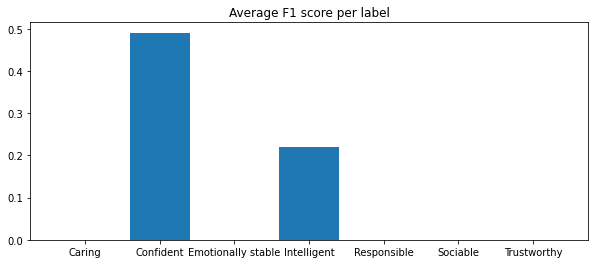

In [86]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title("Average F1 score per label")
plt.show() ;

### いろいろやってみてわかること
 - Predictを見るとわかるが，まったく学習できていない
 - 役に立たない　やはりデータが少なすぎるか